# Movie recommender with multinomial RBM (Tensorflow, GPU)

A Restricted Boltzmann Machine (RBM) is a generative neural network model used to perform unsupervised learning. The main task of an RBM is to learn the joint probability distribution $P(v,h)$, where $v$ are the visible units and $h$ the hidden ones. The hidden units represent latent variables while the visible units are clamped on the input data. Once the joint distribution is learnt, new examples are generated by sampling from it.  

In this notebook, we provide an example of how to utilize the RBM to perform item recommendations. In particular, we use as a case study the [movielens dataset](https://movielens.org), comprising the ranking of movies (from 1 to 5) given by viewers. 

This notebook provides a quick start, showing the basic step to make the algorithm work and how to evaluate its output. A detailed discussion of the RBM model together with a deeper analysis of the recommendation task is provided in the [RBM Deep Dive section](notebooks/02_modeling/rbm_deep_dive.ipynb). The RBM implementation presented here is based on the article by Ruslan Salakhutdinov, Andriy Mnih and Geoffrey Hinton [Restricted Boltzmann Machines for Collaborative Filtering](https://www.cs.toronto.edu/~rsalakhu/papers/rbmcf.pdf) with the exception that here we use multinomial units instead of one-hot encoded. 

### Advantages of RBM: 

The model generates ratings for a user/movie pair using a collaborative filtering based approach. While matrix factorization methods learn how to reproduce an instance of the user/item affinity matrix, the RBM learns the underlying probability distribution. This has several advantages: 

- Generalizability : the model generalize well to new examples.
- Stability in time: if the recommendation task is time-stationary, the model does not need to be trained often to accomodate new ratings/users. 
- Scales well with the size of the dataset and the sparsity of the user/affinity matrix. 
- The tensorflow implementation presented here allows fast training on GPU 

### Notes to use RBM properly:






## 0 Global Settings and Import

In [1]:
#load libraries

from __future__ import print_function
from __future__ import absolute_import
from __future__ import division

# set the environment path to find Recommenders
import sys
sys.path.append("../../")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import papermill as pm
from zipfile import ZipFile

from reco_utils.recommender.rbm.Mrbm_tensorflow import RBM
from reco_utils.dataset.rbm_splitters import splitter

from reco_utils.dataset.url_utils import maybe_download
from reco_utils.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

#For interactive mode only
%load_ext autoreload
%autoreload 2

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4


# 1 Load Data 

Here we select the size of the movielens dataset. In this example we consider an intermediate size consisting of 1 milion ratings provided by approximally 6000 users on 4000 movies. The data are imported in a pandas dataframe including the user ID, the item ID, the ratings and a timestamp denoting when a particular user rated a particular item.  

In [2]:
# Select Movielens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

In [3]:
# MovieLens data have different data-format for each size of dataset 
data_header = None
if MOVIELENS_DATA_SIZE == '100k':
    separator = '\t'
    data_name = 'u.data'
    data_folder = 'ml-100k'
elif MOVIELENS_DATA_SIZE == '1m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-1m'
elif MOVIELENS_DATA_SIZE == '10m':
    separator = '::'
    data_name = 'ratings.dat'
    data_folder = 'ml-10M100K'
elif MOVIELENS_DATA_SIZE == '20m':
    separator = ','
    data_name = 'ratings.csv'
    data_folder = 'ml-20m'
    data_header = 0
else:
    raise ValueError('Invalid data size. Should be one of {100k, 1m, 10m, or 20m}') 

# Download dataset zip file and decompress if haven't done yet
data_path = os.path.join(data_folder, data_name)
if not os.path.exists(data_path):
    filename = 'ml-' + MOVIELENS_DATA_SIZE + '.zip'
    filepath = maybe_download('http://files.grouplens.org/datasets/movielens/'+filename, filename)

    with ZipFile(filepath, 'r') as zf:
        zf.extractall()
    
    # remove zip file we already used
    os.remove(filepath)
    
data = pd.read_csv(
    data_path,
    sep=separator,
    engine='python',
    names=['userID','MovieId','Rating','Timestamp'],
    header=data_header
)
data.head()

,userID,MovieId,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 1.2 Split the data using the stratified splitter  

As a second step we split the data into train and test set. If you are familiar with training supervised learning model, here you will notice the first difference. In the former case, we cut off a certain proportion of training examples from dataset (e.g. images), here corresponding to users (or items), ending up with two matrices (train and test) having different row dimensions. Here we need to mantain the same matrix size for the train and test set, but the two will contain different amounts of ratings, see ... for more details.     

In [4]:
#to use standard names across the analysis 
header = {
        "col_user": "userID",
        "col_item": "MovieId",
        "col_rating": "Rating",
    }

#instantiate the splitter 
split = splitter(DF = data, **header)

Xtr, Xtst, train_df, test_df, maps = split.stratified_split()

Generating the user/item affinity matrix...


Matrix generated, sparsness: 95 % size: (6040, 3706)


The splitter returns several elements: 

- Xtr: a matrix containing the train set ratings 
- Xtst: a matrix containing the test elements 

Note that the train/test matrices have exactly the same same dimension, but different entries.

`train_df` and `test_df` contain the same information as Xtr and Xtst but in dataframe format for later use. finally, `maps` is a dictionary we will use to map back the predicted ratings to their original user/item IDs. 

The `split()` method also returns informations on the sparsness of the dataset all dataset and the size of the user/affinity matrix. The former is a measure of the total number of zeroes (i.e. unrated movies) in the dataset. This is what makes a recommendation task hard: we try to predict 95% of the missing data with only 5% of information! Below we verufy that the generated train and test matrices have exactly the same dimension.    

In [5]:
print('train matrix size', Xtr.shape)
train_df.head()

train matrix size (6040, 3706)


,userID,MovieId,Rating
0,1,1193,5
1,1,745,3
2,1,3186,4
3,1,1566,4
4,1,588,4


In [6]:
print('test matrix size', Xtst.shape)
test_df.head()

test matrix size (6040, 3706)


,userID,MovieId,Rating
0,1,2294,4
1,1,1022,5
2,1,1,5
3,1,2692,4
4,1,531,4


## 2 Train the RBM model

The model has been implemented as a Tensorflow (TF) class. TF does not support probabilistic models natively, so the implementation of the algorithm has a different structure to the one you may be used to see in popular supervised models; for details see ... Also, the class has been implemented so that the TF session is hidden inside the `fit()` method and no explicit call is needed. The algorithm operated in three different steps: 

- Model initialization: This is where we tell TF how to build the computational graph. The main parameters to specify are the number of hidden units, the number of training epochs and the minibatch size. Other parameters can be optionally tweaked for experimentation, as explained in ... 

- Model fit: This is where we train the model on the data. The method takes two arguments: the training and test set matrices. Note that the model is trained **only** on the training set, the set is used to display the generalization accuracy of the trained model, useful to have a first idea on the quality of training. 

- Model prediction: This is where we generate ratings for the unseen items. Once the model has been trained and we are satisfied with its overall accuracy, we sample new ratings from the learned distribution. In particular, we extract the top_k (e.g. 10) most relevant recommendation according to some predefined score. The prediction is then returned in dataframe format ready to be analysed and deployed.  




In [60]:
#First we initialize the model class
model = RBM(hidden_units= 1000, training_epoch = 120, minibatch_size= 1000, **header)

Note that the first time the fit method is called it may take longer to return the result. This is due to the fact that TF needs to initialized the GPU session. You will notice that this is not the case when training the algorithm the second or more times.   

Creating the computational graph


training epoch 0 rmse Train 1.095601 
training epoch 10 rmse Train 0.970192 
training epoch 20 rmse Train 0.949959 
training epoch 30 rmse Train 0.934852 
training epoch 40 rmse Train 0.925662 
training epoch 50 rmse Train 0.919975 
training epoch 60 rmse Train 0.910065 
training epoch 70 rmse Train 0.903867 
training epoch 80 rmse Train 0.894255 
training epoch 90 rmse Train 0.890531 
training epoch 100 rmse Train 0.883892 
training epoch 110 rmse Train 0.877299 
training epoch 120 rmse Train 0.871441 


done training, Training time 40.1325352


precision on the train set 0.39835778
precision on the test set 0.38112506
train/test difference 0.017232716


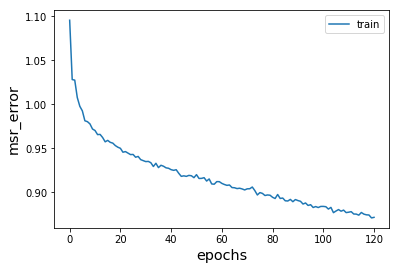

In [61]:
#Model Fit
model.fit(Xtr, Xtst)

During training, we evauate the Root mean squared error to have an idea of how the learning is proceeding. We would generally like to see this quantity decreasing as a function of the learning epochs, as shown in the plot above. The two final scores are the train/test mean average accuracies across the all set together with their difference. Remeber that for a model to generate well the difference between train and test metrics should not be too big. This can be achieved by controlling the regularization of the model; here we use dropout regularization, as explained in ... 

In [62]:
#Model prediction

#number of top score elements to be recommended  
K = 10

#Model prediction on the test set Xtst. Note that we pass 'maps' as a second argument in order to return the correct
#user/item ids in a pandas dataframe format. 
top_k =  model.recommend_k_items(Xtst, maps)

#show the first 10 elements of the dataframe for inspection 
top_k['userID'] = pd.to_numeric(top_k['userID'])
top_k['MovieId'] = pd.to_numeric(top_k['MovieId'])

top_k.head(10)  

Done recommending items, time 0.8948892
Formatting ouput


,userID,MovieId,prediction
0,1,1022,4.989204
1,1,854,4.988661
2,1,3114,4.987366
3,1,2847,4.985618
4,1,811,4.982624
5,1,1,4.981943
6,1,527,4.981680
7,1,3091,4.980321
8,1,966,4.979573
9,1,1056,4.979504


## 4 Evaluation metrics 

Here we evaluate the performance of the algorithm using the metrics provided in the `PythonRankingEvaluation` class. Note that the following metrics take into account only the first K elements, therefore their value may be different from the one displayed from the `model.fit()` method. 

In [30]:
eval_map = map_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                    col_rating="Rating", col_prediction="prediction", 
                    relevancy_method="top_k", k= K)

In [31]:
eval_ndcg = ndcg_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                      col_rating="Rating", col_prediction="prediction", 
                      relevancy_method="top_k", k= K)

In [32]:
eval_precision = precision_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                                col_rating="Rating", col_prediction="prediction", 
                                relevancy_method="top_k", k= K)

In [33]:
eval_recall = recall_at_k(test_df, top_k, col_user="userID", col_item="MovieId", 
                          col_rating="Rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= K)

In [34]:
print("Movielens data size:"+MOVIELENS_DATA_SIZE,
      "Top K:\t%d" % K,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

Movielens data size:1m
Top K:	10
MAP:	0.118197
NDCG:	0.417678
Precision@K:	0.345397
Recall@K:	0.169997


In [ ]:
# Record results with papermill for tests
pm.record("map", eval_map)
pm.record("ndcg", eval_ndcg)
pm.record("precision", eval_precision)
pm.record("recall", eval_recall)